In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout

figsize = (15,9)
plt.rcParams['figure.figsize'] = figsize
pd.set_option('display.float_format', lambda x: '%.2f' % x)

df = pd.read_parquet("/kaggle/input/stock-history/stock-history-features.parquet")
df.insert(9, "close", df.pop("close"))

In [129]:
class StockData:
    def __init__(self, stock, data, look_back=30) -> None:
        self.stock = stock
        self.data = data.query(f"stock == '{stock}'").copy()
        self.data.drop("stock", axis=1, inplace=True)
        self.look_back = look_back
        self.scaler = MinMaxScaler()
        self.data_scaled = self.scaler.fit_transform(self.data)

    def create_sequences(self):
        X, y = [], []
        
        for i in range(len(self.data_scaled) - self.look_back):
            X.append(self.data_scaled[i : i + self.look_back])
            y.append(self.data_scaled[i + self.look_back, -1])
        
        return np.array(X), np.array(y)

    def split(self, train_factor=0.8):
        X, y = self.create_sequences()
        split = int(len(X) * train_factor)
        X_train, y_train = X[:split], y[:split]
        X_test, y_test = X[split:], y[split:]

        return X_train, y_train, X_test, y_test


In [130]:
TSLA = StockData("TSLA", df)
AAPL = StockData("AAPL", df)
GOOG = StockData("GOOG", df)

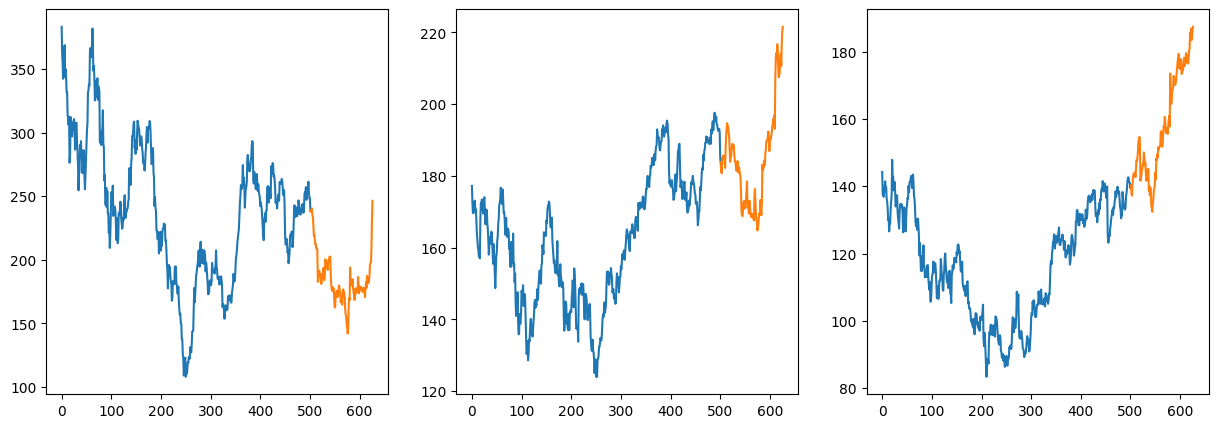

In [131]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes = axes.flatten()

for i, stock in enumerate(df.stock.unique()):
    data = df.query("stock == @stock").copy().reset_index()
    split = int(len(data) * 0.8)
    axes[i].plot(data.loc[:split, 'close'])
    axes[i].plot(data.loc[split:, 'close'])
plt.show()

In [132]:
class LSTM_model:
    def __init__(self, stock, units=64, layers=3, dropout=0.3, dense=[1], activation="tanh"):
        self.data = stock
        self.stock = stock.stock
        self.units = units
        self.dropout = dropout
        self.layers = layers
        self.dense = dense
        self.activation = activation
        self.X_train, self.y_train, self.X_test, self.y_test = stock.split()
        self.model = None

    def build_model(self, optimizer="rmsprop", loss="mean_squared_error"):
        input_shape = self.X_train.shape[1:]
        self.model = Sequential()
        
        if self.layers > 1:
            self.model.add(LSTM(self.units, activation=self.activation, return_sequences=True, input_shape=input_shape))
            self.model.add(Dropout(self.dropout))
            for _ in range(1, self.layers-1):
                self.model.add(LSTM(self.units, activation=self.activation, return_sequences=True))
                self.model.add(Dropout(self.dropout))
            self.model.add(LSTM(self.units))
            self.model.add(Dropout(self.dropout))
        else:
            self.model.add(LSTM(self.units, activation=self.activation, return_sequences=True, input_shape=input_shape))
            self.model.add(Dropout(self.dropout))
            
        for i in self.dense:
            self.model.add(Dense(units=i))

        self.model.compile(optimizer=optimizer, loss=loss)

    def print_summary(self):
        if self.model is None:
            raise ValueError("Model is not defined. Call build_model() first.")
        print(self.model.summary())

    def train(self, epochs=30, batch_size=32, validation_split=0.2, verbose=1):
        if self.model is None:
            raise ValueError("Model is not defined. Call define_model() before training.")

        early_stopping = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=7, mode="min")
        
        self.history = self.model.fit(
            self.X_train,
            self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=[early_stopping],
            verbose=verbose
        )
        
        return self.history

    def evaluate(self):
        if self.model is None:
            raise ValueError(
                "Model is not defined. Call define_model() before training."
            )

        loss = self.model.evaluate(self.X_test, self.y_test)
        print(f"Test Loss: {loss}")
        return loss

    def predict(self):
        if self.model is None:
            raise ValueError(
                "Model is not defined. Call define_model() before training."
            )

        return self.model.predict(self.X_test)
    
    def plot_history(self):
        if self.history is None:
            raise ValueError("No training history found. Train the model first.")

        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title(f'{self.stock} Model Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_predictions(self):
        plt.plot(self.y_test, label='Real', linestyle='-')
        plt.plot(self.predict(), label='Predicted', linestyle='--')
        plt.title(f'{self.stock} Predictions vs True Values')
        plt.xlabel('Samples')
        plt.ylabel('Price')
        plt.legend()
        plt.show()


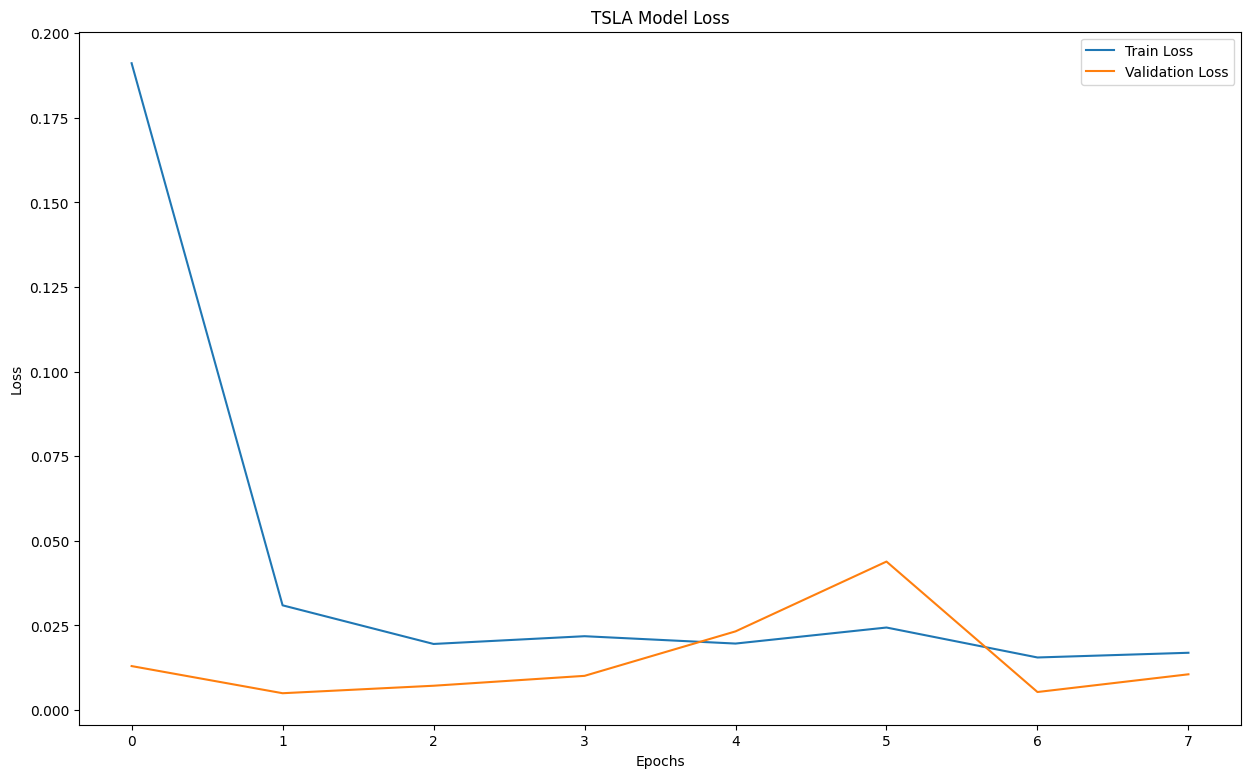

In [148]:
tsla_model = LSTM_model(TSLA, units=200, dropout=0.25, dense=[10,1])
tsla_model.build_model()
tsla_model.train(verbose=0)
tsla_history = tsla_model.plot_history()
tsla_plot = tsla_model.plot_predictions()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


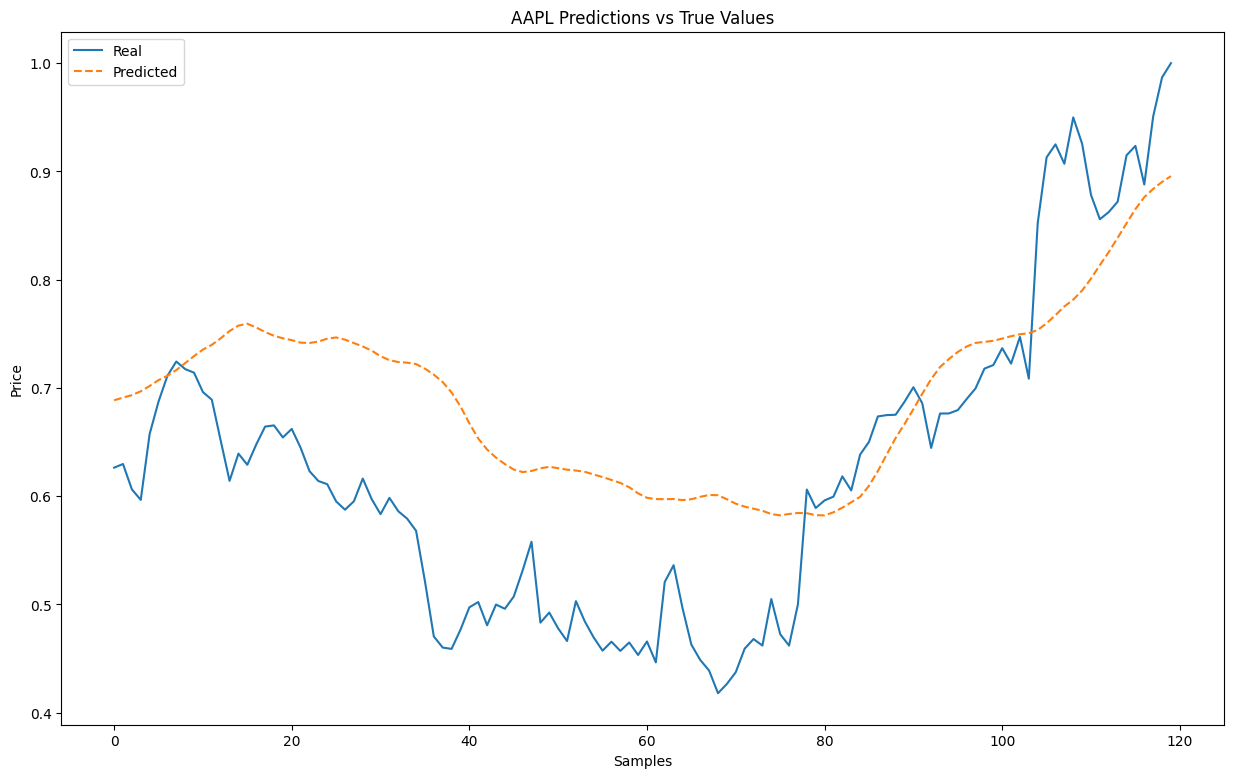

In [153]:
aapl_model = LSTM_model(AAPL, units=140, dropout=0.3, dense=[10, 1])
aapl_model.build_model()
aapl_model.train(verbose=0)
# aapl_model.plot_history()
aapl_model.plot_predictions()

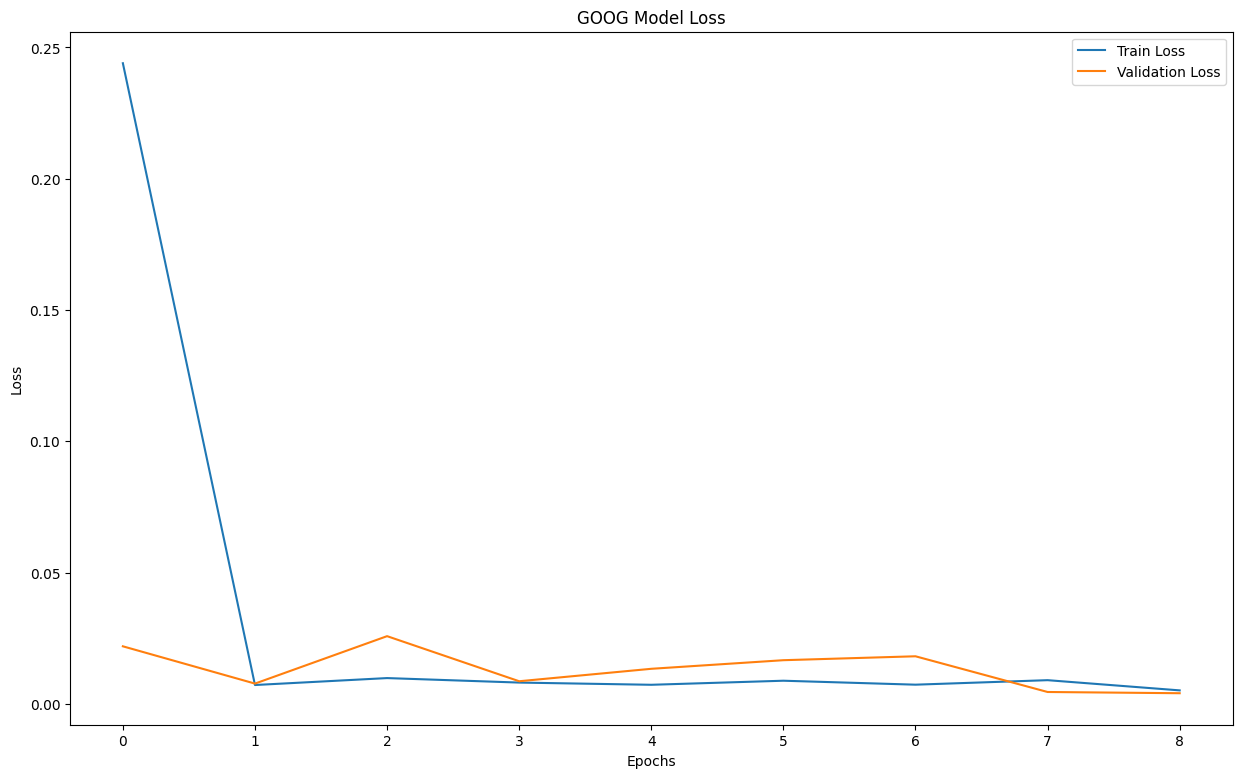

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


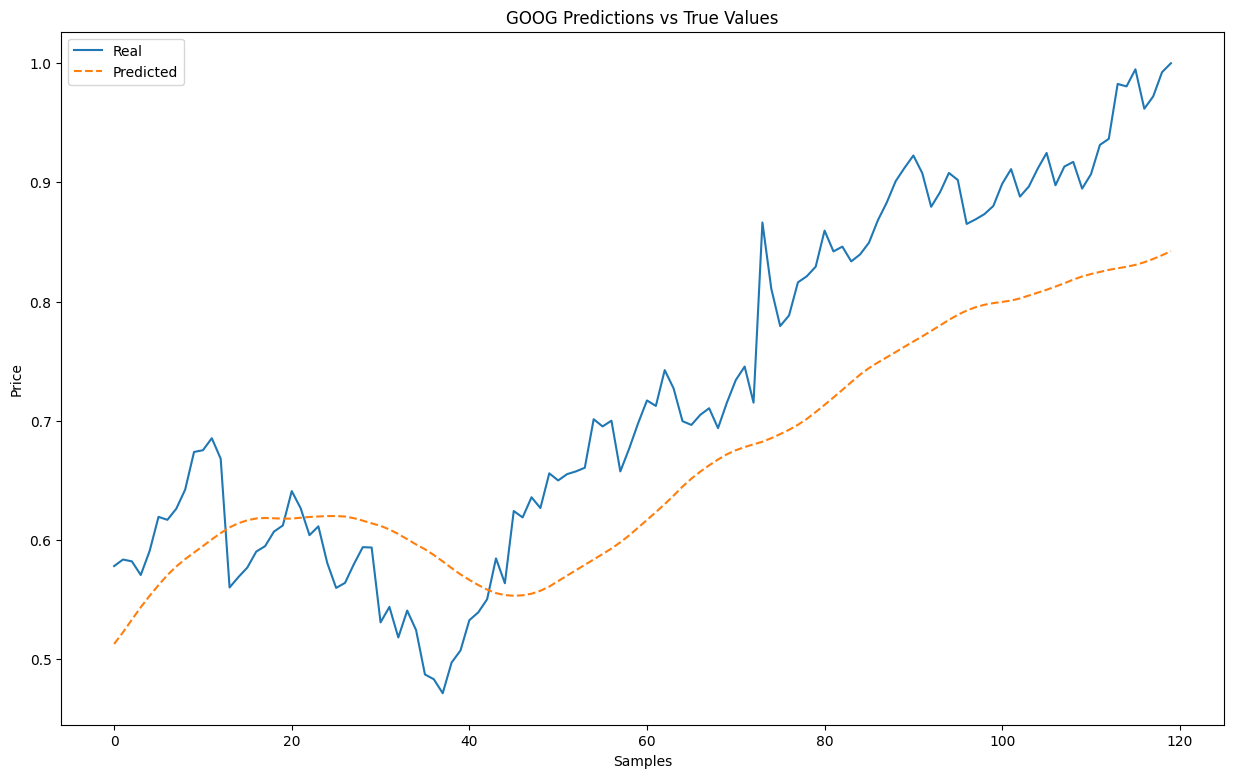

In [162]:
goog_model = LSTM_model(GOOG, units=200, dropout=0.1, dense=[10, 1])
goog_model.build_model()
goog_model.train(verbose=0)
goog_model.plot_history()
goog_model.plot_predictions()